<a href="https://colab.research.google.com/github/Ousmane225/Tp-Spark/blob/master/Boxes_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boxes Processing

Now that have computed the object detection on two sample images, we will display the results, and process them if needed!

## I. Visualization

### I.1. Loading

In [0]:
 !cd /content


In [0]:
%pwd

'/root'

First things first: load the images and the dictionaries saved in pickle format at the end of the last challenge.

In [0]:
### TODO: Load the pickle dicts and the images
import pickle
detec1 = pickle.load(open("/content/detection1.pkl","rb"))
detec2 = pickle.load(open("/content/detection2.pkl","rb"))
detec3 = pickle.load(open("/content/detection3.pkl","rb"))

### I.2. Playing with the labels

To make a proper visualization, we may want the labels as strings, not as integers. For that, we will need to use the label list, which is in `models/research/object_detection/data/mscoco_label_map.pbtxt`, in the folder you cloned in previous challenge. Save the path to this file into the variable `PATH_TO_LABELS`.

Using this path, as well as the functions `load_labelmap`, `convert_label_map_to_categories` and `create_category_index` from the `label_map_util` module, you can get all we will need for visualization!

In [0]:
### TODO: Import label_map_util and define the PATH_TO_LABELS variable
PATH_TO_LABELS = "/content/drive/My Drive/vvdt-inphb-student/models/research/object_detection/data/mscoco_label_map.pbtxt"
#NUM_CLASSES = 80

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%run "/content/drive/My Drive/vvdt-inphb-student/05-Object-Detection/01-Challenges/02-Boxes-Processing/input/label_map_util.py"

In [0]:
import sys
sys.path.append("/content/drive/My Drive/vvdt-inphb-student/05-Object-Detection/01-Challenges/02-Boxes-Processing/input")

In [0]:
from label_map_util import load_labelmap, convert_label_map_to_categories, create_category_index

In [0]:
# Here we use those functions for you
label_map = load_labelmap(PATH_TO_LABELS)
categories = convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = create_category_index(categories)

Play with the created variables and understand what they are.

### 1.3. Visualization of the object detection

Finally, use the function `display_image_with_boxes` provided below, display the images with the corresponding predictions. For each image, print the number of detected objects in the image.

In [0]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def tf_box_to_matplotlib(box, im):
    x = box[1]*im.shape[1]
    y = box[0]*im.shape[0]
    width = (box[3]-box[1])*im.shape[1]
    height = (box[2]-box[0])*im.shape[0]
    
    return x, y, width, height

def display_image_with_boxes(image, dico, threshold=0):

    fig, ax = plt.subplots(1, figsize=(14,10))
    plt.imshow(image)

    for i in range(dico['num_detections']):
        score = dico['detection_scores'][i]
        clas = category_index[dico['detection_classes'][i]]['name']

        if score >= threshold:

            display = str("{:.2f}".format(score))+' '+clas

            x, y, w, h = tf_box_to_matplotlib(dico['detection_boxes'][i], image)
            ax.add_patch(Rectangle((x, y), w, h,linewidth=1,edgecolor='r',facecolor='none'))
            plt.text(x, y-10, display, color='red', fontsize=10)

    plt.axis('off')
    plt.show()

In [0]:
image1 = plt.imread( "/content/drive/My Drive/vvdt-inphb-student/05-Object-Detection/01-Challenges/01-Boxes-Computation/input/image1.jpg")
image2 = plt.imread( "/content/drive/My Drive/vvdt-inphb-student/05-Object-Detection/01-Challenges/01-Boxes-Computation/input/image2.jpg")
image3 = plt.imread( "/content/drive/My Drive/vvdt-inphb-student/05-Object-Detection/01-Challenges/01-Boxes-Computation/input/image3.jpg")

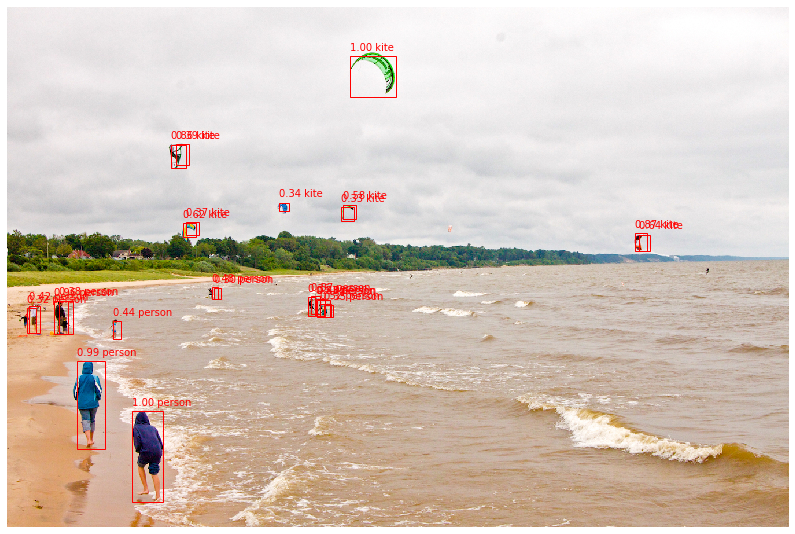

In [0]:
### TODO: use display_image_with_boxes and display the result
display_image_with_boxes(image2, detec2)

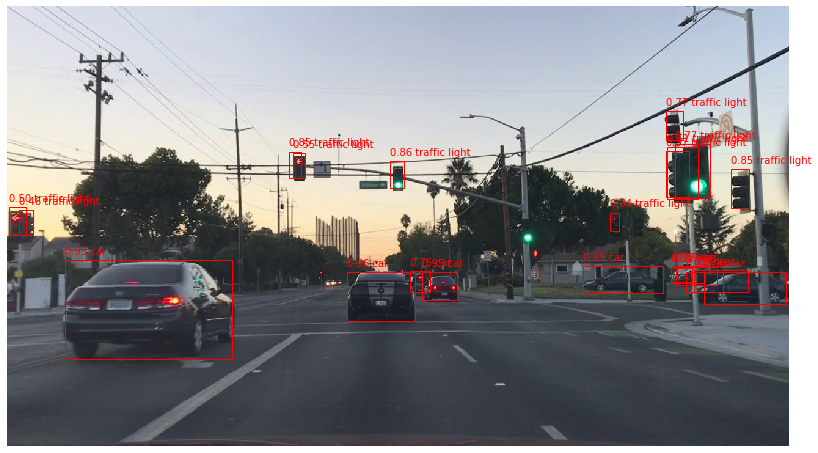

In [0]:
display_image_with_boxes(image3, detec3)

**What do you think?** Is it working good enough? In particular, compare the number of detected object and the number of objects you see in the image.

What could we do to improve our results?

## II. Post processing

We have to perform non max suppression in order to be really consistent. The first step is to compute the Intersection over Union (IoU).

### II.1. IoU

You will implement a function `iou(box1, box2)`, knowing that boxes in the dictionary follow the format `box = [ymin, xmin, ymax, xmax]`.

Computing the IoU may seem easy, but is actually a bit tricky: there are a lot of cases to take into account.

To help you out, consider the following Boxes A and B

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1m1ZmLEdNkMHY3DNiBrCUlOUUO_tlD8zQ">
</p>

The first step is to compute the **intersection** of those two boxes. Implement a function `intersection(boxA, boxB)` that computes the intersection of the boxes A and B.

There are 4 distinct cases to take into account:
- the blue box is on the top left of the red one
- the blue box is on the top right of the red one
- the blue box is on the bottom left of the red one
- the blue box is on the bottom right of the red one

Finally, there is one extreme case: when the two boxes have no intersection.

Feel free to take a sheet of paper and try out all those cases to implement the `intersect` function.

In [0]:
### TODO: implement intersect(box1, box2)
def intersect(box1, box2):
    xx1 = max(box1[1], box2[1])
    yy1 = max(box1[0], box2[0])
    xx2 = min(box1[3], box2[3])
    yy2 = min(box1[2], box2[2])
    
    return max(0, (xx2-xx1))*max(0, (yy2-yy1))

Then you can compute the **union** of those two boxes. One can notice that the union is nothing but area of the two boxes, minus the intersection:
$$
union(A, B) = area(A) + area(B) - intersection(A, B)
$$

Now implement the function `union(boxA, boxB)`.

In [0]:
### TODO: implement union(box1, box2)
def union(box1, box2):
    import numpy as np
    un = np.abs((box1[2]-box1[0])*(box1[3]-box1[1])) + np.abs((box2[2]-box2[0])*(box2[3]-box2[1])) - intersect(box1, box2)
    return un

Finally, implement the function `iou(box1, box2)` using the two functions you just implemented.

In [0]:
### TODO: implement iou(box1, box2)
def iou(box1, box2):
  i = intersect(box1, box2)
  u = union(box1, box2)
  return i/u

In [0]:
detec1.keys()

dict_keys(['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes'])

In [0]:
box1 = detec1["detection_boxes"][1]
box2 = detec1["detection_boxes"][2]
len(detec1["detection_boxes"])

100

In [0]:
%precision 3
intersect(detec1["detection_boxes"][1], detec1["detection_boxes"][2])

0.000

In [0]:
detec1["detection_boxes"][1], detec1["detection_boxes"][2]

(array([0.028, 0.033, 0.867, 0.315], dtype=float32),
 array([0.   , 0.701, 0.1  , 0.796], dtype=float32))

To make sure it works, feel free to test your IoU function on several examples.

### II.2. Non max suppression

Now comes the big part: you will have to implement the `non_max_suppression` function.

This function will take as input a dictionary (output of TensorFlow computed in previous challenge), a iou threshold and a detection threshold. This function should output a dictionary containing only the non supressed boxes and detections.

An easier way would be to make two functions. First, implement a function `apply_detection_threshold(detections, detection_threshold)` that removes all the boxes below a given `detection_threshold`.

Then, implement a function `non_max_suppression(detections, iou_threshold, detection_threshold)`. This function applies the detection threshold first with `detection_threshold`. Then, loop over all the boxes, keep the highest score, and remove all the boxes with an IoU below the `iou_threshold`, until there is no box left.

This is a quite complicated function to write, do not worry if you struggle at some point.

In [0]:
### TODO: implement the non_max_suppresion function


### II.3. Visualize new results

Now apply your implemented function `non_max_suppression` and display the new results reusing your previous code. Is it better now? Are there as much boxes as objects?

In [1]:
### TODO: apply non_max_suppression and display the results
! git status

fatal: not a git repository (or any of the parent directories): .git
